# **Chen Portsia - ML Course - Assignment 2**

>This notebook presents my solution for Assignment 2 in the Machine Learning course taught by *Prof. Lev Muchnik* at the *Hebrew University*, Winter 2024.
>
>**Contents:**
>1. **LDA Topic Modeling on News Articles** – Preprocessing a corpus of news articles and applying Latent Dirichlet Allocation (LDA) to discover hidden topics.
>2. **Word2Vec Movie Similarity Analysis** – Training Word2Vec models on movie rating sequences to find similarities between movies and evaluate model performance.
>3. **Word2Vec Tweets Analysis** – Preprocessing tweets, training a Word2Vec model, and analyzing word similarities and bigrams within the Twitter dataset.
>
>Created by: **Chen Portsia**

### **Task 1:** Gain insight about a corpus with LDA

In [20]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import gensim
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Load the data
articles_file_name = "nytimes_news_articles.csv.zip"
df = pd.read_csv(articles_file_name, compression='zip')

# Display the data
print("Data shape:", df.shape, "\n")
print(df.head())

Data shape: (8888, 2) 

                                                 url  \
0  http://www.nytimes.com/2016/06/30/sports/baseb...   
1  http://www.nytimes.com/2016/06/30/nyregion/may...   
2  http://www.nytimes.com/2016/06/30/nyregion/thr...   
3  http://www.nytimes.com/2016/06/30/nyregion/tek...   
4  http://www.nytimes.com/2016/06/30/sports/olymp...   

                                                text  
0  WASHINGTON — Stellar pitching kept the Mets af...  
1  Mayor Bill de Blasio’s counsel and chief legal...  
2  In the early morning hours of Labor Day last y...  
3  It was the Apple Store in New York City before...  
4  OMAHA — The United States Olympic swimming tri...  


### **Preprocessing the Articles**
Before training the LDA model, we applied the following preprocessing steps:
- Removed missing values from the text column.
- Tokenized the text using `gensim.simple_preprocess`, which converts text to lowercase and removes punctuation.
- Removed common English stopwords to focus on meaningful words.
- Filtered out short documents with fewer than three words.
- Removed duplicate articles to ensure unique content.
- Removed short articles with less than 3 words
- Created a **bag-of-words (BoW)** representation using `gensim.corpora.Dictionary`, filtering out extremely rare words (appearing in fewer than 10 documents) and overly common words (appearing in more than 10% of documents).

In [6]:
# Preprocess the data
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords', force=False, quiet=True)
stopwords = set(nltk.corpus.stopwords.words('english'))

# Fill NaN values in 'text' column with empty string
df['text'] = df['text'].fillna('')

# Preprocess the data using gensim simple_preprocess and remove stopwords
df['tokens'] = df['text'].apply(lambda x: [word for word in simple_preprocess(x) if word not in stopwords])
number_of_articles = df.shape[0]

# Filter rows with less than 3 words
df = df[df['tokens'].apply(len) > 2]
print(f"Removed {number_of_articles - df.shape[0]} rows with less than 3 words.")

# Remove duplicated articles
df = df.drop_duplicates(subset='tokens')
print(f"Removed {number_of_articles - df.shape[0]} duplicated articles.")

Removed 4 rows with less than 3 words.
Removed 22 duplicated articles.


In [7]:
print("Random 5 articles:","\n")
for i in df.sample(3).index:
    print(f"Article {i}:\n{df.loc[i, 'text']}")
    print(f"Number of words in article: {len(df.loc[i, 'text'])}\n")
    print(f"Tockens:\n{df.loc[i, 'tokens']}")
    print(f"Number of tokens in article: {len(df.loc[i, 'tokens'])}\n")
    print(f"{'-'*100}\n")

Random 5 articles: 

Article 1997:
WASHINGTON — The F.B.I. director said on Monday that the gunman in the mass killing in Orlando was on a terrorist watchlist from 2013 to 2014, but that months of intense investigation into his foreign travels, his inflammatory language with co-workers and his possible motivations did not produce enough evidence to arrest him.
The director, James B. Comey Jr., defended his agency’s handling of its past inquiries into the gunman, Omar Mateen, telling reporters that there had been no indication that F.B.I. agents in Florida missed any chances to apprehend or prosecute Mr. Mateen before the deadly rampage in which he proclaimed his allegiance to the Islamic State.
The attack highlighted the difficulty the American government faces in addressing the threat from the terrorist group. Unlike Al Qaeda, which favored highly organized and planned operations, the Islamic State has encouraged anyone to take up arms in its name. Often, that means the F.B.I. is look

In [8]:
from gensim import corpora

# Create a dictionary representation of the documents.
dictionary = corpora.Dictionary(df['tokens'])

# Filter out very rare and very common words.
dictionary.filter_extremes(no_below=10, no_above=0.1)

# Create a bag of words(bow) representation of the documents.
corpus = [dictionary.doc2bow(text) for text in df['tokens']]

print("Number of documents:", len(corpus))
print("Number of unique tokens:", len(dictionary))

Number of documents: 8866
Number of unique tokens: 21864


In [9]:
import pyLDAvis
import pyLDAvis.gensim_models

# pyLDAvis.enable_notebook()

def visualize_topics(model, corpus, dictionary):
    lda_display = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
    return pyLDAvis.display(lda_display)

### **Training LDA Models**
We trained LDA models with different numbers of topics: **2, 5, 10, 20, and 30**. Each model was trained using **10 passes** to ensure convergence. By comparing these models, we aimed to determine the best number of topics that provide a meaningful division of the corpus. Presenting the results using pyLDAvis, offers us a good grasp of the performance of the model and the number of topics.

In [10]:
from gensim.models import LdaModel

topic_numbers = [2,5,10,20,30]

# Train LDA models with different number of topics
models = []
for num_topics in topic_numbers:
    model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10, random_state=42)
    models.append(model)

# Visualize the topics for each model
for i, model in enumerate(models):
    print(f"Number of topics: {topic_numbers[i]}")
    display(visualize_topics(model, corpus, dictionary))

Number of topics: 2


Number of topics: 5


Number of topics: 10


Number of topics: 20


Number of topics: 30


### **Choosing the Optimal Number of Topics**
While a high number of topics can capture more specific themes, excessive segmentation may lead to overlapping topics. For example, articles related to *family* might also fall under *movies* or *social issues*. To find the optimal number of topics, we used **pyLDAvis** to visualize topic distributions. 

From the number of topics we examined (2,5,10,20,30), our findings indicate that **10 topics** provided a well-balanced classification as the 2D PCA displays, with distinct topic clusters and minimal overlap between articles.  

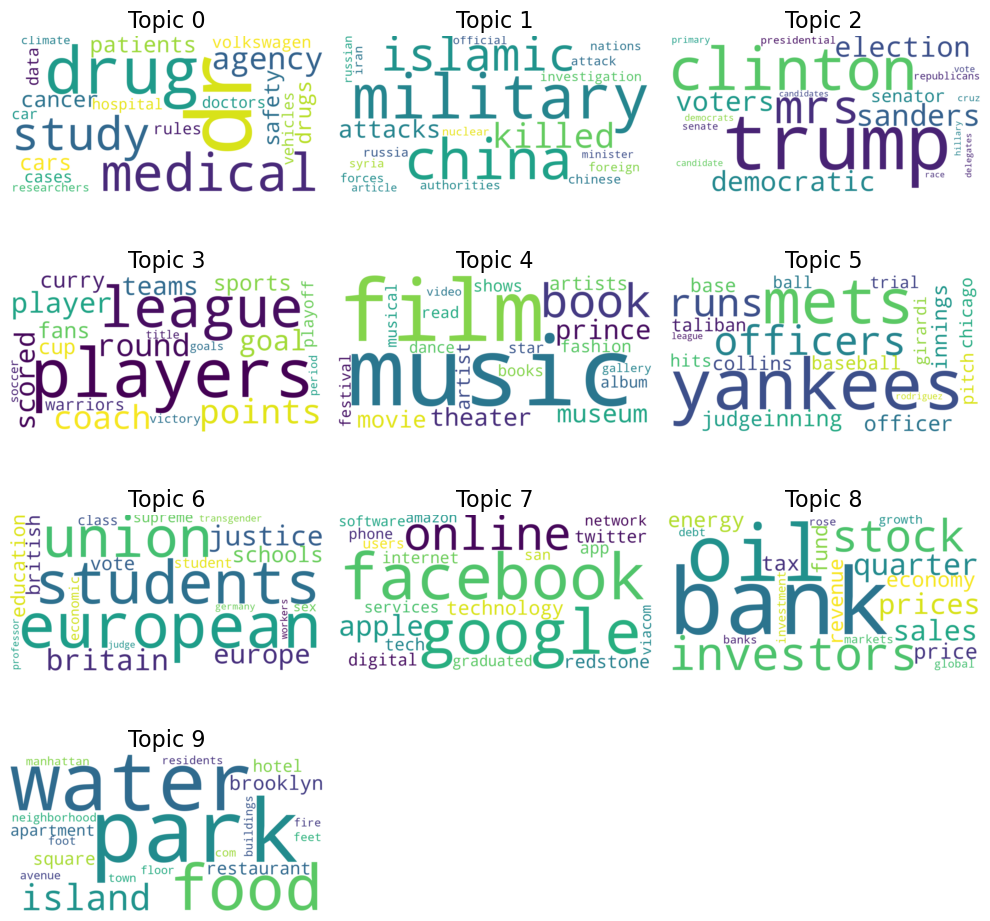

In [11]:
from wordcloud import WordCloud

optimal_num_topics = 10
optimal_model = models[topic_numbers.index(optimal_num_topics)]

# Plot word clouds for each topic
def plot_word_clouds(lda_model, num_topics):
    cols = 3
    rows = (num_topics // cols) + (num_topics % cols > 0)
    fig, axes = plt.subplots(rows, cols, figsize=(10, (rows * 5)-10))
    axes = axes.flatten() 
    
    for t in range(num_topics):
        plt.sca(axes[t])
        topic_words = dict(lda_model.show_topic(t, topn=20))
        wordcloud = WordCloud(background_color='white',
                              width=1200,
                              height=600).generate_from_frequencies(topic_words)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f"Topic {t}", fontsize=16)
        plt.axis('off')
        
    # Remove any unused subplots
    for j in range(t + 1, len(axes)):
        fig.delaxes(axes[j])
        
    plt.tight_layout()
    plt.show()

plot_word_clouds(optimal_model, optimal_num_topics)

By examining the most frequent words in each topic, we can assign the following labels:

#### **Topic Labels and Interpretations:**
1. **Medical & Science** – (dr, drug, medical, patients, cancer, researchers, hospital, safety)
2. **International Affairs & Military** – (military, china, russia, attack, iran, nuclear, nations, forces)
3. **US Politics & Elections** – (trump, clinton, election, voters, senate, democrats, republicans, candidates)
4. **Sports & Athletics** – (players, league, coach, teams, playoff, soccer, victory, sports)
5. **Arts & Entertainment** – (music, film, book, theater, movie, artists, dance, festival, gallery)
6. **Baseball & Local Crime** – (yankees, mets, officers, judge, inning, baseball, trial, chicago)
7. **Education & Society** – (students, union, britain, schools, education, transgender, workers, justice)
8. **Technology & Internet** – (facebook, google, apple, twitter, digital, tech, software, amazon, users)
9. **Finance & Economy** – (bank, oil, investors, stock, economy, sales, investment, markets, debt)
10. **Real Estate & Urban Life** – (park, water, food, neighborhood, apartment, brooklyn, buildings, residents)

### **Task 2:** Word2vec movies similarities

In [12]:
# Load the data
ratings_pickle_path = "movie_ratings/movie_ratings.pickle.zip"
movies_pickle_path = "movie_ratings/movies.pickle"

# Load the movies data
df_ratings = pd.read_pickle(ratings_pickle_path)
# Load the ratings data
df_movies = pd.read_pickle(movies_pickle_path)

print(f"df_ratings shape: {df_ratings.shape}")
print(f"df_movies shape: {df_movies.shape}")
print(f"Number of unique movies: {df_movies['title'].nunique()}")
print(f"Number of unique users: {len(df_ratings)}")
genres = df_movies.columns[df_movies.columns.str.startswith('genre_')]
print(f"Number of genres: {len(genres)}")
print(f"Number of unique years: {df_movies['year'].nunique()}")

movie_rating_seq = df_ratings.tolist()

display(df_movies.head())

df_ratings shape: (138493,)
df_movies shape: (27278, 22)
Number of unique movies: 27262
Number of unique users: 138493
Number of genres: 20
Number of unique years: 118


,title,year,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,genre_Fantasy,genre_Romance,genre_Drama,genre_Action,...,genre_Horror,genre_Mystery,genre_Sci-Fi,genre_IMAX,genre_Documentary,genre_War,genre_Musical,genre_Western,genre_Film-Noir,genre_(no genres listed)
movieId,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),1995.0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Jumanji (1995),1995.0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Grumpier Old Men (1995),1995.0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Waiting to Exhale (1995),1995.0,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
5,Father of the Bride Part II (1995),1995.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
print("Example of movie rating sequence:")
for i in range(5):
    print(movie_rating_seq[i])
print()
print("Shortest movie rating sequence:", min(len(seq) for seq in movie_rating_seq))
print("Longest movie rating sequence:", max(len(seq) for seq in movie_rating_seq))
print("Average movie rating sequence length:", round(np.mean([len(seq) for seq in movie_rating_seq]),2))
print("Median movie rating sequence length:", np.median([len(seq) for seq in movie_rating_seq]))
print("Standard deviation of movie rating sequence length:", round(np.std([len(seq) for seq in movie_rating_seq]),2))

Example of movie rating sequence:
['2001: A Space Odyssey (1968)', 'Wizard of Oz, The (1939)', 'Austin Powers: The Spy Who Shagged Me (1999)', 'Contact (1997)', 'Fish Called Wanda, A (1988)', 'Dragonheart (1996)', 'Fight Club (1999)', "What's Eating Gilbert Grape (1993)", 'Butch Cassidy and the Sundance Kid (1969)', 'Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)', 'Rob Roy (1995)', 'Rumble in the Bronx (Hont faan kui) (1995)', 'Star Trek II: The Wrath of Khan (1982)', 'Dead Poets Society (1989)', 'Die Hard 2 (1990)', 'Edward Scissorhands (1990)', 'Shrek (2001)', 'Alien (1979)', 'Young Frankenstein (1974)', 'Shining, The (1980)', 'Psycho (1960)', 'Ringu (Ring) (1998)', 'Others, The (2001)', 'Ghostbusters (a.k.a. Ghost Busters) (1984)', 'Frankenstein (1931)', 'Freaks (1932)', 'Exorcist, The (1973)', '28 Days Later (2002)', 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)', 'American Werewolf in London, An (1981)', 'Bubba Ho-tep (2002)', 'Thing, The (1982)', 'Army of Da

In [18]:
unique_movies = set()
for seq in movie_rating_seq:
  unique_movies.update(seq)

print("Number of unique movies:", len(unique_movies), "\n")

movie_counts = pd.Series([m for seq in movie_rating_seq for m in seq]).value_counts()

print("10 most ranked movies:")
print(movie_counts.head(10))

Number of unique movies: 26729 

10 most ranked movies:
Pulp Fiction (1994)                          67310
Forrest Gump (1994)                          66172
Shawshank Redemption, The (1994)             63366
Silence of the Lambs, The (1991)             63299
Jurassic Park (1993)                         59715
Star Wars: Episode IV - A New Hope (1977)    54502
Braveheart (1995)                            53769
Terminator 2: Judgment Day (1991)            52244
Matrix, The (1999)                           51334
Schindler's List (1993)                      50054
Name: count, dtype: int64


### **Word2vec model training:**

1. **Preprocessing the sequences**:  
   - The `preprocess_sequences` function ensures that very long user rating sequences do not dominate the training process. By truncating sequences to a maximum length (`max_seq_length=1000`), we avoid overly large “sentences” that might bias the model or slow training.  

2. **Training or loading the Word2Vec model** (`train_or_load_w2v`):
   - **Model Loading**: We first check if a pre-trained model with the same hyperparameters already exists. If it does, we simply load it to save time.  
   - **Model Training**: If a model does not exist, we train a new one using the given parameters. Key Word2Vec hyperparameters include:
     - **`sg`**: Switches between skip-gram (`sg=1`) and CBOW (`sg=0`). Skip-gram can yield good results for infrequent items, while CBOW can be faster for frequent items.  
     - **`window`**: Defines the maximum distance between the current movie (word) and its context in the sequence.  
     - **`epochs`**: Number of training iterations; more epochs can capture deeper relationships.  
     - **`min_count`**: Ignores movies (words) that appear fewer than `min_count` times, reducing noise.  
     - **`vector_size`** (or `vec_size`): Dimensionality of the embedding space.  
     - **`sample`**: Subsampling frequent words/movies to reduce their dominance.  
   - We also specify a `negative` sampling of `10` to improve training efficiency, and set a fixed `seed` for reproducibility.

3. **Multiple Models with Different Hyperparameters**:  
   - We define a series of parameter dictionaries (`model_1_params` through `model_8_params`), varying factors like skip-gram vs. CBOW (`sg`), embedding size (`vec_size`), context window size (`window`), and minimum frequency threshold (`min_count`).  
   - Each set of parameters is passed to `train_or_load_w2v` to produce a uniquely configured Word2Vec model.  
   - By training several models with different hyperparameters, we can compare which settings best capture meaningful relationships between movies in user rating sequences. This experimentation helps tune the model for subsequent tasks like recommendations or similarity searches.

Overall, **the goal** is to produce movie embeddings that **reflect the connection between movies**, while controlling for very long sequences and experimenting with different hyperparameter settings to find the most effective configuration.

During the training, I tried multiple sets of configurations, more than presented here, and found out that most of the parameters had only a small influence over the similarities. The main configurations and techniques that improved the results the most are all methods of balancing the data.

In [21]:
from gensim.models import Word2Vec

def preprocess_sequences(movie_seq, max_seq_length=1000):
    processed_seq = []
    for seq in movie_seq:
        if len(seq) > max_seq_length:
            processed_seq.append(seq[:max_seq_length])
        else:
            processed_seq.append(seq)
    return processed_seq

def train_or_load_w2v(window, epochs, sg, min_count, vec_size, movie_seq, sample=1e-3):
    model_dir = "movie_ratings_models"
    os.makedirs(model_dir, exist_ok=True)
    model_filename = f"movie_w2v_sg={sg}_window={window}_epochs={epochs}_min_count={min_count}_vec_size={vec_size}.model"
    model_path = os.path.join(model_dir, model_filename)

    if os.path.exists(model_path):
        print(f"Loading existing Word2Vec model from {model_path}...")
        model = Word2Vec.load(model_path)
    else:
        print(f"Training Word2Vec model with sg={sg}, window={window}, epochs={epochs}, min_count={min_count}, vec_size={vec_size}...")
        # Preprocess sequences
        processed_seq = preprocess_sequences(movie_seq)
        
        model = Word2Vec(
            sentences=processed_seq,
            vector_size=vec_size,
            window=window,
            min_count=min_count,
            sg=sg,
            epochs=epochs,
            workers=os.cpu_count()-1,
            seed=42,
            negative=10,
            sample=1e-4,
        )
        
        model.save(model_path)
        print(f"Model trained and saved to {model_path}.")
    
    return model

model_1_params = {"window": 5, "epochs": 20, "sg": 1, "min_count": 1, "vec_size": 100}
model_2_params = {"window": 5, "epochs": 20, "sg": 1, "min_count": 100, "vec_size": 100}
model_3_params = {"window": 5, "epochs": 20, "sg": 1, "min_count": 1000, "vec_size": 100}
model_4_params = {"window": 5, "epochs": 20, "sg": 0, "min_count": 1000, "vec_size": 100}
model_5_params = {"window": 3, "epochs": 20, "sg": 1, "min_count": 1, "vec_size": 50}
model_6_params = {"window": 3, "epochs": 20, "sg": 1, "min_count": 100, "vec_size": 50}
model_7_params = {"window": 3, "epochs": 20, "sg": 1, "min_count": 1000, "vec_size": 30}
model_8_params = {"window": 3, "epochs": 20, "sg": 0, "min_count": 1000, "vec_size": 30}


model_1 = train_or_load_w2v(movie_seq=movie_rating_seq, **model_1_params)
model_2 = train_or_load_w2v(movie_seq=movie_rating_seq, **model_2_params)
model_3 = train_or_load_w2v(movie_seq=movie_rating_seq, **model_3_params)
model_4 = train_or_load_w2v(movie_seq=movie_rating_seq, **model_4_params)
model_5 = train_or_load_w2v(movie_seq=movie_rating_seq, **model_5_params)
model_6 = train_or_load_w2v(movie_seq=movie_rating_seq, **model_6_params)
model_7 = train_or_load_w2v(movie_seq=movie_rating_seq, **model_7_params)
model_8 = train_or_load_w2v(movie_seq=movie_rating_seq, **model_8_params)

Loading existing Word2Vec model from movie_ratings_models\movie_w2v_sg=1_window=5_epochs=20_min_count=1_vec_size=100.model...
Loading existing Word2Vec model from movie_ratings_models\movie_w2v_sg=1_window=5_epochs=20_min_count=100_vec_size=100.model...
Loading existing Word2Vec model from movie_ratings_models\movie_w2v_sg=1_window=5_epochs=20_min_count=1000_vec_size=100.model...
Loading existing Word2Vec model from movie_ratings_models\movie_w2v_sg=0_window=5_epochs=20_min_count=1000_vec_size=100.model...
Loading existing Word2Vec model from movie_ratings_models\movie_w2v_sg=1_window=3_epochs=20_min_count=1_vec_size=50.model...
Loading existing Word2Vec model from movie_ratings_models\movie_w2v_sg=1_window=3_epochs=20_min_count=100_vec_size=50.model...
Loading existing Word2Vec model from movie_ratings_models\movie_w2v_sg=1_window=3_epochs=20_min_count=1000_vec_size=30.model...
Loading existing Word2Vec model from movie_ratings_models\movie_w2v_sg=0_window=3_epochs=20_min_count=1000_v

In [22]:
# Merge movie_counts with df_movies using title
df_movies = df_movies.merge(movie_counts, left_on='title', right_index=True)
# Create a new column with all ganers of the movie seperated by '|'
df_movies['all_genres'] = df_movies.filter(regex='^genre_')\
  .apply(lambda row: '|'.join(row.index[row == 1].str.replace('genre_', '')), axis=1)

In [23]:
example_movies = [
    "Toy Story (1995)", 
    "Schindler's List (1993)", 
    "Titanic (1997)",
    "Gladiator (2000)",
    "Jurassic Park (1993)"
]

models = {
    'model_1': model_1,
    'model_2': model_2,
    'model_3': model_3,
    'model_4': model_4,
    'model_5': model_5,
    'model_6': model_6,
    'model_7': model_7,
    'model_8': model_8
}

def model_evaluation(models, movie_title, topn=20):
    df_results = pd.DataFrame()
    for model_name, model in models.items():
        try:
            similar_movies = model.wv.most_similar(movie_title, topn=topn)
            similar_movies = [m for m, _ in similar_movies]
            similar_movies_genres = df_movies[df_movies['title'].isin(similar_movies)]['all_genres'].str.get_dummies(sep='|')
            genres_ratio = similar_movies_genres.mean()
            df_results[model_name] = genres_ratio
        except:
            print(f"Model {model_name} doesn't contain all the movies in the list")
      # Sort the ganers by the original movie ganers
    movie_genres = df_movies[df_movies['title']==movie_title]['all_genres'].values[0].split('|')
    valid_genres = [genre for genre in movie_genres if genre in df_results.index]
    df_results = df_results.loc[valid_genres].sort_index(ascending=False)
    models_avg_score = df_results.mean(axis=0)
    return df_results.style.background_gradient(cmap='coolwarm', axis=1).format("{:.2f}"), models_avg_score

models_avg_scores = {}
for movie in example_movies:
    print(f"Ganers of the movie {movie}: {df_movies[df_movies['title']==movie]['all_genres'].values[0]}")
    print(f"Ganers distribution of the 100 most similar movies from each model:")
    display(model_evaluation(models, movie, topn=100)[0])
    models_avg_scores[movie] = model_evaluation(models, movie, topn=100)[1]
    print()

print("Average scores of the models for each movie:")
df_avg_scores = pd.DataFrame(models_avg_scores)
display(df_avg_scores.style.background_gradient(cmap='coolwarm', axis=0).format("{:.2f}"))

print("The model with the highest average score among all movies:")
best_model = df_avg_scores.mean(axis=1).idxmax()
print(best_model)

Ganers of the movie Toy Story (1995): Adventure|Animation|Children|Comedy|Fantasy
Ganers distribution of the 100 most similar movies from each model:


,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8
Fantasy,0.13,0.17,0.18,0.16,0.13,0.18,0.16,0.16
Comedy,0.43,0.50,0.49,0.38,0.39,0.49,0.38,0.37
Children,0.19,0.21,0.22,0.18,0.15,0.22,0.19,0.18
Animation,0.18,0.19,0.21,0.15,0.15,0.21,0.16,0.15
Adventure,0.31,0.34,0.35,0.44,0.29,0.35,0.38,0.46



Ganers of the movie Schindler's List (1993): Drama|War
Ganers distribution of the 100 most similar movies from each model:


,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8
War,0.09,0.13,0.13,0.10,0.11,0.15,0.10,0.10
Drama,0.59,0.64,0.65,0.55,0.58,0.65,0.61,0.56



Ganers of the movie Titanic (1997): Romance|Drama
Ganers distribution of the 100 most similar movies from each model:


,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8
Romance,0.31,0.32,0.28,0.24,0.29,0.28,0.25,0.23
Drama,0.50,0.48,0.43,0.35,0.51,0.45,0.40,0.35



Ganers of the movie Gladiator (2000): Adventure|Drama|Action
Ganers distribution of the 100 most similar movies from each model:


,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8
Drama,0.52,0.39,0.37,0.28,0.48,0.35,0.35,0.28
Adventure,0.22,0.33,0.32,0.43,0.25,0.36,0.39,0.45
Action,0.32,0.48,0.49,0.56,0.36,0.55,0.53,0.54



Ganers of the movie Jurassic Park (1993): Adventure|Action|Thriller|Sci-Fi
Ganers distribution of the 100 most similar movies from each model:


,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8
Thriller,0.35,0.39,0.41,0.44,0.35,0.39,0.38,0.41
Sci-Fi,0.25,0.35,0.36,0.31,0.22,0.36,0.31,0.33
Adventure,0.35,0.40,0.39,0.45,0.32,0.40,0.40,0.46
Action,0.42,0.54,0.53,0.54,0.40,0.52,0.52,0.55



Average scores of the models for each movie:


,Toy Story (1995),Schindler's List (1993),Titanic (1997),Gladiator (2000),Jurassic Park (1993)
model_1,0.25,0.34,0.41,0.35,0.34
model_2,0.28,0.39,0.40,0.40,0.42
model_3,0.29,0.39,0.35,0.39,0.42
model_4,0.26,0.33,0.29,0.42,0.43
model_5,0.22,0.34,0.40,0.36,0.32
model_6,0.29,0.40,0.36,0.42,0.42
model_7,0.25,0.36,0.32,0.42,0.40
model_8,0.26,0.33,0.29,0.42,0.44


The model with the highest average score among all movies:
model_6


### **Choosing the best model:**

>The evaluation metric assesses the quality of movie embeddings by comparing the genre distribution of the most similar movies (according to each model) to the actual genres of a given target movie.<br>
>**All in all** we don't see a big differences between models performence and it is hard to indicate whether the difference between the models are significant<br>
>Interestingly, balancing the data, such as **truncating long sequences and filtering out infrequent movies**, had the most noticeable impact on improving recommendations.<br> While some models maintained strong performance across multiple movies, others struggled with certain genres, highlighting that no single configuration is universally optimal across all cases.<br>
>
>**Note:** We need to take the evaluation metric in a grain of salte since we understand that the metric is not comprehensive since there are manually sampled smell number of movies. I also assume that the genres show something about the connections between the movies, which is not necessarily true.

In [24]:
def find_similar_movies(model, movie_title, topn=10):
  similar = model.wv.most_similar(movie_title, topn=topn)
  df_similar = pd.DataFrame(similar, columns=["title", "similarity_score"])
  df_similar = df_similar.merge(df_movies[["title", "year", "all_genres"]], on="title", how="left")
  df_similar = df_similar.sort_values(by="similarity_score", ascending=False)
  df_similar["similarity_score"] = df_similar["similarity_score"].apply(lambda x: round(x, 3))
  return df_similar

test_movies = [
    "Lion King, The (1994)",
    "Matrix, The (1999)",
    "Shrek (2001)"
]
for movie in test_movies:
    print(f"Most similar movies to {movie}:")
    print(f"Movie's genres: {df_movies[df_movies['title']==movie]['all_genres'].values[0]}")
    display(find_similar_movies(models[best_model], movie, topn=5))
    print()

Most similar movies to Lion King, The (1994):
Movie's genres: Adventure|Animation|Children|Drama|IMAX|Musical


,title,similarity_score,year,all_genres
0,Beauty and the Beast (1991),0.866,1991.0,Animation|Children|Fantasy|Romance|IMAX|Musical
1,Babe (1995),0.824,1995.0,Children|Drama
2,Aladdin (1992),0.792,1992.0,Adventure|Animation|Children|Comedy|Musical
3,Aladdin (1992),0.792,1992.0,Adventure|Animation|Children|Comedy|Fantasy
4,Seven (a.k.a. Se7en) (1995),0.754,1995.0,Thriller|Mystery
5,Mrs. Doubtfire (1993),0.751,1993.0,Comedy|Drama



Most similar movies to Matrix, The (1999):
Movie's genres: Action|Thriller|Sci-Fi


,title,similarity_score,year,all_genres
0,Star Wars: Episode V - The Empire Strikes Back...,0.850,1980.0,Adventure|Action|Sci-Fi
1,Saving Private Ryan (1998),0.837,1998.0,Drama|Action|War
2,Raiders of the Lost Ark (Indiana Jones and the...,0.791,1981.0,Adventure|Action
3,"Sixth Sense, The (1999)",0.766,1999.0,Drama|Horror|Mystery
4,Fight Club (1999),0.752,1999.0,Drama|Action|Crime|Thriller



Most similar movies to Shrek (2001):
Movie's genres: Adventure|Animation|Children|Comedy|Fantasy|Romance


,title,similarity_score,year,all_genres
0,"Monsters, Inc. (2001)",0.870,2001.0,Adventure|Animation|Children|Comedy|Fantasy
1,"Crouching Tiger, Hidden Dragon (Wo hu cang lon...",0.852,2000.0,Romance|Drama|Action
2,"Lord of the Rings: The Fellowship of the Ring,...",0.819,2001.0,Adventure|Fantasy
3,Ocean's Eleven (2001),0.799,2001.0,Crime|Thriller
4,Finding Nemo (2003),0.790,2003.0,Adventure|Animation|Children|Comedy


### **Model manual evaluation:**
> Here, I selected a set of movies that were not used in the evaluation function to assess the model's performance. <br>
> Overall, the model does a relatively good job of identifying similar movies, though not perfectly, based on my understanding and familiarity with the suggested recommendations. <br>
> To improve results, we could further investigate the **imbalance in the data** and explore ways to better represent **highly popular movies**, ensuring they do not disproportionately influence the learned embeddings.

In [25]:
all_movies = set(df_movies['title'])
model_vocab = set(models[best_model].wv.index_to_key) 

missing_movies = all_movies - model_vocab
print(f"Number of missing movies: {len(missing_movies)}")
print("Some missing movies:") 
print(f"Number of movies in df_movies: {len(df_movies)}")
for i, movie in enumerate(missing_movies):
  print(movie)
  if i == 4:
    break

Number of missing movies: 18920
Some missing movies:
Number of movies in df_movies: 26745
Muppet Musicians of Bremen, The (1972)
Eden of the East the Movie I: The King of Eden (Higashi no Eden Gekijoban) (2009)
Maskerade (1934)
Jerry and Tom (1998)
Will It Snow For Christmas? (Y'aura-t-il de la neige à Noël?) (1996)


In [26]:
all_genres = set('|'.join(df_movies['all_genres']).split('|'))  # Get all unique genres
genre_coverage = {genre: 0 for genre in all_genres}

for movie in models[best_model].wv.index_to_key:
    movie_genres = df_movies[df_movies['title'] == movie]['all_genres'].values
    if len(movie_genres) > 0:
        genres = movie_genres[0].split('|')
        for genre in genres:
            genre_coverage[genre] += 1

# Sort genres by coverage
sorted_genre_coverage = sorted(genre_coverage.items(), key=lambda x: x[1])
print("Underrepresented genres:", sorted_genre_coverage[:5])  # Show lowest coverage genres

Underrepresented genres: [('(no genres listed)', 0), ('Film-Noir', 83), ('IMAX', 144), ('Western', 162), ('Documentary', 295)]


### Can you find which movies didn’t get proper representation?

>There are a couple of reasons for movies not to get proper representation, here are some:
>- **Missing Movies**: A total of **18,920 movies** are absent from the model’s vocabulary, likely due to low frequency in user sequences. Examples include *Chapiteau-show (2011)* and *Whispering Corridors (1998)*, suggesting that **less popular or region-specific films were filtered out**.  
>- **Underrepresented Genres**: The model struggles with **rare genres** like *Film-Noir*, *IMAX*, and *Western*, which have significantly fewer movies in the dataset. This indicates **genre imbalance**, where certain >categories don’t have enough data to establish strong embeddings.  

### **Task 3:** Tweets explorations using Word2vec

### **Word2vec model training for tweets analysis:**

1. **Preprocessing the data:** 
    - Cleaned tweets by removing URL, punctuation, lowering etc.
    - Tokenized the cleaned tweets into individual words.
    - Removing short tweets.

2. **Pharsing Bigrams:**
    - Trained a bigram model to detect common phrases in the tweets.
    - Applied the bigram model to the tokenized tweets to form bigrams.

3. **Training the Word2Vec model:**
    - Trained a Word2Vec model on the tokenized tweets with bigrams.
    - Used parameters like vector size, window size, and minimum word count to optimize the model.

In [14]:
import bz2

file_path = "twitter/twitter-stream.txt.bz2"

tweets = []
with bz2.open(file_path, 'rt', encoding='utf-8') as file:
    for line_number, line in enumerate(file, start=1):
        tweets.append(line.strip())

tweets_df = pd.DataFrame(tweets, columns=['tweets'])

tweets_df.head()

,tweets
0,"RT @lavendaire: 😸 “Happy” can be a place, a pe..."
1,Put in Helinski
2,RT @lacollenoire: no offense but money would s...
3,Gm @imVkohli V want double hundred 🙌🙌
4,RT @Qdafool_RS: I did all dat shit for you💯🖤


In [ ]:
import re, string

def preprocess_line(line):
  if line.lower().startswith('rt '): # remove leading "RT "
    line = line[3:]
  line = re.sub(r'http\S+', '', line).lower() # remove URLs and lowercase
  # remove punctuation
  punctuation = string.punctuation.replace('@','').replace('#', '')
  line = line.translate(str.maketrans(' ', ' ', punctuation))
  # remove leading and trailing spaces
  line = line.strip()
  return line

tweets_df['cleaned_tweets'] = tweets_df['tweets'].apply(preprocess_line)

In [38]:
import random
for i in random.sample(range(len(tweets_df)), 10):
    print("Original:", tweets_df['tweets'].iloc[i])
    print("Cleaned:", tweets_df['cleaned_tweets'].iloc[i])
    print()

Original: RT @DineshDSouza: Not enough! He should resign from Congress https://t.co/2I71zXRcSH
Cleaned: @dineshdsouza not enough he should resign from congress

Original: @later890 @BBCWorld Last time I checked, the vast majority of Britons were in favour of border controls. Your comme… https://t.co/mkq7EiUJkC
Cleaned: @later890 @bbcworld last time i checked the vast majority of britons were in favour of border controls your comme…

Original: I hate when mfs drive below or at the speed limit OMG GET TF OFF THE ROAD IF YOU NOT GOING 20 OVER
Cleaned: i hate when mfs drive below or at the speed limit omg get tf off the road if you not going 20 over

Original: RT @RealKhallid: can't hang around people who have no goals or ambitions
Cleaned: @realkhallid cant hang around people who have no goals or ambitions

Original: RT @Jessiabellaa: DIDDLE IS HAVING A 24 HOUR BLACK FRIDAY EXTENDED SALE 😍 EVERYTHING IS FREE!! JUST PAY SHIPPING!!…
Cleaned: @jessiabellaa diddle is having a 24 hour black fr

In [41]:
# Remove tweets with less than 3 words
tweets_df['tokens'] = tweets_df['cleaned_tweets'].apply(lambda x: x.split())
tweets_df = tweets_df[tweets_df['tokens'].apply(len) > 2]

In [42]:
from gensim.models.phrases import Phrases, Phraser

# Train bigram model
bigram_model = Phrases(tweets_df['tokens'], min_count=3, threshold=100)
bigram_phraser = Phraser(bigram_model)

# Apply bigram model to sentences
tweets_bigrams = [bigram_phraser[tokens] for tokens in tweets_df['tokens']]

In [45]:
from gensim.models import Word2Vec

# Train Word2Vec model
model = Word2Vec(sentences=tweets_bigrams, vector_size=100, window=5, min_count=10, workers=os.cpu_count()-1)

In [62]:
sample_words = ['economy', 'angry', 'israel', 'music','speling']
for word in sample_words:
    print(f"Similar words to '{word}':")
    try:
        similar_words = model.wv.most_similar(word, topn=5)
        for similar_word, score in similar_words:
            print(f"- {similar_word} ({score:.2f})")
    except:
        print(f"Word '{word}' not in vocabulary")
    print()

Similar words to 'economy':
- economic_growth (0.75)
- infrastructure (0.68)
- government (0.67)
- investment (0.67)
- debt (0.66)

Similar words to 'angry':
- upset (0.73)
- mad (0.69)
- anxious (0.68)
- bitter (0.67)
- annoyed (0.66)

Similar words to 'israel':
- #israel (0.84)
- iran (0.83)
- #syria (0.81)
- palestine (0.81)
- saudi_arabia (0.80)

Similar words to 'music':
- songs (0.70)
- song (0.67)
- playlist (0.62)
- edm (0.59)
- hiphop (0.58)

Similar words to 'speling':
Word 'speling' not in vocabulary



### **Model performens demonstration:**
>The Word2Vec model appears to perform largely as expected:
>- **Semantic Similarity**: The model successfully captures semantic relationships between words. For instance, "angry" is grouped with synonyms like "upset," "mad," and "annoyed," and "economy" is linked to related concepts like "economic_growth" and "investment."
>- **Named Entities and Hashtags**: The model treats named entities and hashtags similarly, as seen with “israel” being associated with “#israel” and geopolitical terms like “iran” and “palestine".
>- **Domain-Specific Bias**: The presence of terms like "#syria" and "iran" in the "israel" results hints that the model's dataset may be skewed towards political discussions rather than neutral geographic or cultural associations.
>- **Handling of Misspellings**: The model does not recognize “speling,” which is expected since Word2Vec that trained on a limited amount of data, does not handle out-of-vocabulary words unless trained on them. In addition, as part of the training process, words that appear less than 10 times are filtered out.

### **Bigram analysis:**

>This script analyzes bigrams in a trained Word2Vec model to assess whether they are represented as the sum of their individual word vectors or >have developed distinct meanings.
>A high similarity score suggests that the bigram vector closely approximates the sum of its component word vectors, while a low score indicates >that the bigram has taken on a unique meaning in the vector space.
>
>**Script process:**
>1. **Filter by Frequency**: Retains only bigrams that appear at least 2,000 times in the corpus.
>2. **Validate Bigrams**: Excludes bigrams where either word is missing from the model’s vocabulary.
>3. **Retrieve Word Vectors**: 
>     - Extracts vectors for the valid bigrams.
>     - Computes the sum of the individual word vectors forming each bigram.
>4. **Compute Cosine Similarity**:
>     - Calculates the dot product between the bigram vector and the sum of its individual word vectors.
>     - Normalizes this value using the product of vector norms.
>     - Produces a cosine similarity score, indicating how closely the bigram vector aligns with its component words.

In [ ]:
bigrams = [word for word in model.wv.index_to_key if '_' in word]
bigram_counts = pd.DataFrame([(bigram, model.wv.get_vecattr(bigram, 'count')) for bigram in bigrams],
                             columns=['bigram', 'count'])
bigram_counts = bigram_counts.sort_values('count', ascending=False)
bigram_counts = bigram_counts[bigram_counts['count'] > 2000] 

# Filter out bigrams with words not in the model's vocabulary
valid_bigrams = [bg for bg in bigram_counts['bigram'] if all(word in model.wv for word in bg.split('_'))]
bg_arrays = np.vstack([model.wv[bg] for bg in valid_bigrams])
sum_arrays = np.vstack([model.wv[w.split('_')[0]] + model.wv[w.split('_')[1]] for w in valid_bigrams])
dots = np.sum(sum_arrays * bg_arrays, axis=1)
norms = np.linalg.norm(sum_arrays, axis=1) * np.linalg.norm(bg_arrays, axis=1)
cosine_similarity = dots / norms
bigram_counts['bigram_words_sim'] = np.nan  # Initialize with NaN
bigram_counts.loc[bigram_counts['bigram'].isin(valid_bigrams), 'bigram_words_sim'] = np.round(np.abs(cosine_similarity), 2)

In [53]:
bigram_counts.sort_values('bigram_words_sim', ascending=False).head(10)

,bigram,count,bigram_words_sim
33,sexual_harassment,3115,0.82
4,rachel_peters,8254,0.80
24,tax_bill,4204,0.80
10,donald_trump,6403,0.78
18,meghan_markle,4852,0.77
0,#missuniverse_#philippines,24003,0.74
60,eli_manning,2103,0.74
41,@avengers_#infinitywar,2556,0.74
14,roy_moore,5752,0.74
3,#missuniverse_#thailand,11266,0.72


In [54]:
bigram_counts.sort_values('bigram_words_sim', ascending=True).head(10)

,bigram,count,bigram_words_sim
2,automatically_checked,12186,0.05
35,st_jude,2873,0.14
50,anywhere_else,2291,0.16
61,red_carpet,2102,0.18
45,asian_style,2387,0.21
34,todays_stats,2914,0.21
16,black_friday,5108,0.23
29,theaters_may,3615,0.24
36,animal_crossing,2829,0.24
11,new_york,6398,0.27


>The results suggest that bigrams with **high similarity** (e.g., *donald_trump*, *meghan_markle*, *tax_bill*) are composed of words that frequently appear together and retain their individual meanings when combined. These are often **named entities (people, places, events, hashtags)** or well-defined phrases, where the meaning is largely the sum of the parts. For example, *sexual_harassment* can frequently replaced with the word *harassment*, and *donald_trump* can be replaced with the word *trump*.
>
>Conversely, bigrams with **low similarity** (e.g., *red_carpet*, *anywhere_else*, *black_friday*) likely represent **idiomatic expressions, compound phrases, or conceptually distinct terms** where the combined meaning differs significantly from the sum of the individual words. This suggests that the Word2Vec model has learned unique representations for these phrases rather than treating them as simple word combinations.For example the words *new* and *york* have different definitions than *new_york*.

In [55]:
wordsim_path = r"twitter/wordsim353.tsv"
questions_words_path = r"twitter/questions-words.txt"

# Create dataset comparing word similarities on wordsim353
wordsim_comparisons = []
with open(wordsim_path, 'r', encoding='utf-8') as f:
    for line in f:
        if line.startswith("#"):
            continue
        parts = line.strip().split("\t")
        if len(parts) == 3:
            w1, w2, human_score = parts
            human_score = float(human_score)
            # Only compute similarity if both words are in the trained model's vocabulary
            if w1 in model.wv and w2 in model.wv:
                model_sim = model.wv.similarity(w1, w2)
            else:
                model_sim = np.nan
            wordsim_comparisons.append((w1, w2, human_score, model_sim))

wordsim_df = pd.DataFrame(wordsim_comparisons, columns=["word1", "word2", "human_score", "model_similarity"])
print("Wordsim353 comparisons:")
print(wordsim_df.head())

Wordsim353 comparisons:
      word1     word2  human_score  model_similarity
0      love       sex         6.77          0.157480
1     tiger       cat         7.35          0.383390
2     tiger     tiger        10.00          1.000000
3      book     paper         7.46          0.588793
4  computer  keyboard         7.62          0.645478


In [56]:
# Evaluate analogy task using the questions_words dataset
analogy_results = model.wv.evaluate_word_analogies(questions_words_path)

analogy_stats = []
# analogy_results[1] contains per-section details
for section in analogy_results[1]:
    sec = section["section"]
    correct = len(section["correct"])
    incorrect = len(section["incorrect"])
    total = correct + incorrect
    acc = correct / total if total else np.nan
    analogy_stats.append((sec, correct, incorrect, acc))

analogy_df = pd.DataFrame(analogy_stats, columns=["section", "num_correct", "num_incorrect", "accuracy"])
print("\nAnalogy evaluation per section:")
print(analogy_df)


Analogy evaluation per section:
                        section  num_correct  num_incorrect  accuracy
0      capital-common-countries           34            472  0.067194
1                 capital-world           44           1169  0.036274
2                      currency            1            205  0.004854
3                 city-in-state           27           2440  0.010944
4                        family          200            262  0.432900
5     gram1-adjective-to-adverb           16            914  0.017204
6                gram2-opposite           28            572  0.046667
7             gram3-comparative          570            762  0.427928
8             gram4-superlative          311            811  0.277184
9      gram5-present-participle          435            557  0.438508
10  gram6-nationality-adjective          121           1178  0.093149
11             gram7-past-tense          565            917  0.381242
12                 gram8-plural          294           10

### How well the Word2Vec model aligns with human judgment

>**Word Similarity Results**
>- The `wordsim353` dataset contains human-judged similarity scores for word pairs.
>- The model's similarity scores (e.g., `love-sex: 0.16`, `tiger-cat: 0.38`) show that the Word2Vec model captures some semantic relationships but with lower correlation than human scores.
>- The **perfect score** for `tiger-tiger` (1.0) confirms that the model properly recognizes identical words.
>- However, some word pairs (e.g., `love-sex`, `tiger-cat`) have relatively low model similarity compared to human judgments, suggesting that the model might not fully capture certain semantic relationships.
>
>**Word Analogy Results**
>- The `questions-words` dataset evaluates analogy tasks (e.g., *Paris is to France as Berlin is to ?*).
>- The model achieves **an overall accuracy of ~19.9%**, meaning it correctly answers about **1 in 5 analogies**.
>- Performance varies by category:
>  - **High accuracy** in linguistic transformations like *comparatives* (42.7%), *past tense* (38.1%), and *present participles* (43.9%), indicating that the model learns word inflection well.
>  - **Lower accuracy** in conceptual relationships like *capital cities* (6.7%), *currencies* (0.5%), and *nationalities* (9.3%), showing that the model struggles with factual world knowledge.
>
>The model performs **moderately well** in recognizing word similarities and linguistic patterns but struggles with **factual and geographical analogies**. This suggests that the training data may be biased toward linguistic usage rather than structured world knowledge.

In [ ]:
import gensim.downloader as api

# Load pre-trained Word2Vec model related to the Twitter dataset
twitter_w2v_model = api.load('glove-twitter-100')
wiki_w2v_model = api.load('glove-wiki-gigaword-100')

In [84]:
import gensim
wordsim353 = "twitter/wordsim353.tsv"

def safe_evaluate(model, file_path):
	import numpy as np
	from scipy.stats import pearsonr, spearmanr
	human_scores = []
	model_scores = []
	oov_count = 0
	total = 0
	with open(file_path, 'r', encoding='utf-8') as f:
		for line in f:
			if line.startswith('#'):
				continue
			parts = line.strip().split('\t')
			if len(parts) != 3:
				continue
			w1, w2, human_score = parts
			total += 1
			try:
				try:
					sim = model.similarity(w1, w2)
				except AttributeError:
					sim = model.wv.similarity(w1, w2)
				human_scores.append(float(human_score))
				model_scores.append(sim)
			except KeyError:
				oov_count += 1
	pearson_correlation = pearsonr(human_scores, model_scores)
	spearman_correlation = spearmanr(human_scores, model_scores)
	oov_ratio = oov_count / total if total else np.nan
	return pearson_correlation, spearman_correlation, oov_ratio

person_corr_pretrained, spearman_corr_pretrained, oov_ratio_pretrained = safe_evaluate(twitter_w2v_model, wordsim353)
person_corr_wiki, spearman_corr_wiki, oov_ratio_wiki = safe_evaluate(wiki_w2v_model, wordsim353)
persin_corr, spearman_corr, oov_ratio = safe_evaluate(model, wordsim353)

print("Custom model evaluation:")
print(f"Pearson correlation: {persin_corr[0]:.4f}")
print(f"Spearman correlation: {spearman_corr[0]:.4}")
print(f"OOV ratio: {oov_ratio:.4f}")
print(f"Vocabulary size: {len(model.wv)}")
print("\nPre-trained model evaluation - 'glove-twitter-100':")
print(f"Pearson correlation: {person_corr_pretrained[0]:.4f}")
print(f"Spearman correlation: {spearman_corr_pretrained[0]:.4f}")
print(f"OOV ratio: {oov_ratio_pretrained:.4f}")
print(f"Vocabulary size: {len(twitter_w2v_model)}")
print("\nPre-trained model evaluation - 'glove-wiki-gigaword-100':")
print(f"Pearson correlation: {person_corr_wiki[0]:.4f}")
print(f"Spearman correlation: {spearman_corr_wiki[0]:.4f}")
print(f"OOV ratio: {oov_ratio_wiki:.4f}")
print(f"Vocabulary size: {len(wiki_w2v_model)}")

Custom model evaluation:
Pearson correlation: 0.4894
Spearman correlation: 0.4861
OOV ratio: 0.0623
Vocabulary size: 185486

Pre-trained model evaluation - 'glove-twitter-100':
Pearson correlation: 0.5265
Spearman correlation: 0.5212
OOV ratio: 0.0538
Vocabulary size: 1193514

Pre-trained model evaluation - 'glove-wiki-gigaword-100':
Pearson correlation: 0.5463
Spearman correlation: 0.5276
OOV ratio: 0.0510
Vocabulary size: 400000


### **Model Evaluation:**

>The comparison evaluates **word similarity performance** across three models: 
>1. **Custom Word2Vec model (trained on tweets)**
>2. **Pretrained GloVe-Twitter-100**
>3. **Pretrained GloVe-Wiki-Gigaword-100**
>
>#### **Key Insights:**
>
>1. **Similarity Performance (Pearson & Spearman Correlations)**
>   - The **pretrained models outperform the custom model** in both Pearson and Spearman correlation.
>   - The **Wiki-trained model (0.5463 Pearson, 0.5276 Spearman)** performs best, showing the highest agreement with human judgment.
>   - The **Twitter-trained GloVe model (0.5265 Pearson, 0.5212 Spearman)** follows closely, suggesting it captures social media-specific word relationships well.
>   - The **custom Word2Vec model (0.4894 Pearson, 0.4861 Spearman)** performs slightly worse than both, likely due to its smaller training corpus.
>
>2. **Vocabulary Coverage (OOV Ratio & Size)**
>   - The **custom model has the highest OOV ratio (6.23%)**, meaning it lacks more words from WordSim-353 than the pretrained models.
>   - The **GloVe-Wiki model has the lowest OOV ratio (5.1%)**, indicating broader word coverage.
>   - The **pretrained Twitter model has the largest vocabulary (1.19M words)**, explaining its relatively strong performance.
>
>3. **Training Data Impact**
>   - The **custom model’s lower correlation scores** suggest that its training data (tweets) may be **more domain-specific** and less representative of general word similarity.
>   - The **pretrained Twitter model**, trained on a much larger dataset, outperforms the custom model, demonstrating the advantage of large-scale training.
>   - The **Wiki model's superior performance** suggests that encyclopedic text provides a richer understanding of word relationships than social media data.
>
>The **custom model performs decently but is outperformed by both pretrained models**, particularly in **word similarity alignment with human judgments**. Its **higher OOV ratio and smaller vocabulary** suggest it is more limited in scope. If better performance is needed, **training on a larger, more diverse dataset or fine-tuning a pretrained model** could improve results.